In [1]:
import casadi as ca
import numpy as np

import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt

$\phi(x) = \frac{1}{2} x^{T} A x - b^{T}x$

In [2]:
Nx = 2
N_iter = 10
x_lim = 5
y_lim = 5
delta = 1

x_init = ca.DM([2,2])

diag_1 = 1
diag_2 = 10
b1 = 1
b2 = 1
x_SX = ca.SX.sym('x',Nx)    
A = ca.diag([diag_1,diag_2])
b = ca.DM([b1,b2])
f = 1/2 * x_SX.T @ A @ x_SX - b.T @ x_SX
# f = x_SX[0] ** 2 + ca.sin(x_SX[1]) 

f_func = ca.Function("f_func",[x_SX],[f])
# H,g = ca.hessian(f,x_SX)

# grad_func = ca.Function("grad_func", [x_SX],[g])
# hessian_func = ca.Function("hessian_func", [x_SX],[H])

In [3]:
def cholesky_factorization_LL(A):
    '''
    LL.T form
    ''' 
    n = np.shape(A)[0]
    L = np.zeros([n,n])
    for i in range(n):
        L[i,i] = np.sqrt(A[i,i])
        if i + 1 > n-1:
            return L
        for j in range(i + 1, n):
            L[j,i] = A[j,i] / L[i,i]
            for k in range(i+1, j+1): # Be careful of the implementation in Python: j + 1
                A[j,k] = A[j,k] - L[j,i] * L[k,i]

In [4]:
def strong_Wolfe_condition(f_func, grad_func, c1, c2, xk, pk):
    alpha = 1
    while(True):
        if alpha <= 1e-9:
            return alpha
        cond_armijo = (f_func(xk + alpha * pk) <= f_func(xk) + c1 * alpha * grad_func(xk).T @ pk)
        cond_curvature = ca.fabs((grad_func(xk + alpha * pk).T @ pk) <= c2 * ca.fabs(grad_func(xk).T @ pk))
        if cond_armijo == True and cond_curvature == True:
            return alpha
        else: alpha = alpha * 0.9

In [5]:
def plot_phi(f_func,xk,pk,alpha_sel):
    alpha = np.arange(0,1,0.01)
    N_alpha = np.shape(alpha)[0]

    phi_list = []

    for i in range(N_alpha):
        alpha_i = alpha[i]
        phi_list += [f_func(xk + alpha_i * pk).full().flatten().tolist()]
    
    fig, ax = plt.subplots()
    ax.plot(alpha,phi_list)
    ax.scatter(alpha_sel,f_func(xk + alpha_sel * pk).full().flatten().tolist(),s=50, color='r', zorder = 10, label='alpha =' + str(alpha_sel)) 
    ax.legend()

In [6]:
def CG_Preliminary(A, b, x0, N_iter):
    r0 = A @ x0 - b
    p0 = -r0
    
    rk = r0
    pk = p0
    xk = x0
    
    x_sol_list = []
    x_sol_list += xk.full().flatten().tolist()
    for i in range(N_iter):
        alpha_k = - (rk.T @ pk) / (pk.T @ A @ pk)
        xk_next = xk + alpha_k * pk
        rk_next = A @ xk_next - b
        beta_k_next = (rk_next.T @ A @ pk) / (pk.T @ A @ pk)
        pk_next = -rk_next + beta_k_next * pk
        # update
        rk = rk_next
        pk = pk_next
        xk = xk_next
        print("p"+str(i), pk)
        x_sol_list += xk.full().flatten().tolist()
    
    return x_sol_list

In [7]:
def CG(A, b, x0, N_iter):
    r0 = A @ x0 - b
    p0 = -r0
    
    rk = r0
    pk = p0
    xk = x0
    
    x_sol_list = []
    x_sol_list += xk.full().flatten().tolist()
    for i in range(N_iter):
        alpha_k = (rk.T @ rk) / (pk.T @ A @ pk)
        xk_next = xk + alpha_k * pk
        rk_next = rk + alpha_k * A @ pk
        beta_k_next = (rk_next.T @ rk_next) / (rk.T @ rk)
        pk_next = - rk_next + beta_k_next * pk
        # update
        rk = rk_next
        pk = pk_next
        xk = xk_next
        print("x"+str(i), xk)
        x_sol_list += xk.full().flatten().tolist()
    
    return x_sol_list

In [8]:
def Preconditioned_CG(A, b, x0, N_iter):
    
    L = cholesky_factorization_LL(A)    #  In practice, we should select a sparser approximate factor than the lower triangle matrix.
    n = np.shape(A)[0]
    L_approx = L
    L_approx[n-1,0] = 0 
    M = L_approx @ L_approx.T
    
    r0 = A @ x0 - b

    y0 = np.linalg.solve(M,r0)
    p0 = -y0
    
    rk = r0
    pk = p0
    xk = x0
    yk = y0

    x_sol_list = []
    x_sol_list += xk.full().flatten().tolist()
    for i in range(N_iter):
        alpha_k = (rk.T @yk) / (pk.T @ A @ pk)
        xk_next = xk + alpha_k * pk
        rk_next = rk + alpha_k * A @ pk
        
        yk_next = np.linalg.solve(M,rk_next)
        
        beta_k_next = (rk_next.T @ yk_next) / (rk.T @ yk)
        pk_next = - rk_next + beta_k_next * pk
        # update
        rk = rk_next
        pk = pk_next
        xk = xk_next
        yk = yk_next
        print("x"+str(i), xk)
        x_sol_list += xk.full().flatten().tolist()
    
    return x_sol_list

In [9]:
x_list = CG_Preliminary(A,b,x_init,N_iter)

p0 [-0.901993, 0.00474733]
p1 [7.00999e-17, 1.3319e-15]
p2 [0, 0]
p3 [nan, nan]
p4 [nan, nan]
p5 [nan, nan]
p6 [nan, nan]
p7 [nan, nan]
p8 [nan, nan]
p9 [nan, nan]


nan


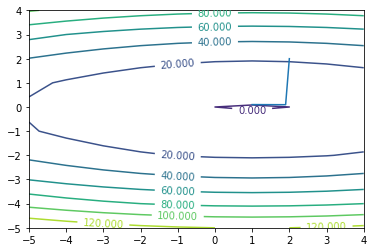

In [10]:
x = np.arange(-x_lim, x_lim, delta)
y = np.arange(-y_lim, y_lim, delta)
X, Y = np.meshgrid(x, y)
Z =1/2 * (diag_1 * X **2 + diag_2 * Y ** 2) - b1 * X + b2 * Y
fig, ax = plt.subplots()
x1 = x_list[::2]
x2 = x_list[1::2]
ax.plot(x1,x2)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
print(f_func([x1[-1],x2[-1]]))

In [11]:
x_list = CG(A,b,x_init,N_iter)

x0 [1.89975, 0.0952645]
x1 [1, 0.1]
x2 [1, 0.1]
x3 [1, 0.1]
x4 [1, 0.1]
x5 [1, 0.1]
x6 [1, 0.1]
x7 [1, 0.1]
x8 [1, 0.1]
x9 [1, 0.1]


In [12]:
x_list

[2.0,
 2.0,
 1.8997507615618943,
 0.0952644696759899,
 1.0,
 0.09999999999999946,
 1.0,
 0.09999999999999983,
 1.0,
 0.09999999999999983,
 1.0,
 0.09999999999999983,
 1.0,
 0.09999999999999983,
 1.0,
 0.09999999999999983,
 1.0,
 0.09999999999999983,
 1.0,
 0.09999999999999983,
 1.0,
 0.09999999999999983]

-0.55


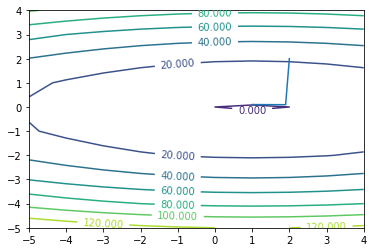

In [13]:
x = np.arange(-x_lim, x_lim, delta)
y = np.arange(-y_lim, y_lim, delta)
X, Y = np.meshgrid(x, y)
Z =1/2 * (diag_1 * X **2 + diag_2 * Y ** 2) - b1 * X + b2 * Y
fig, ax = plt.subplots()
x1 = x_list[::2]
x2 = x_list[1::2]
ax.plot(x1,x2)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
print(f_func([x1[-1],x2[-1]]))

In [14]:
x_list = Preconditioned_CG(A,b,x_init,N_iter)

x0 [1, 0.1]
x1 [1, 0.1]
x2 [1, 0.1]
x3 [1, 0.1]
x4 [1, 0.1]
x5 [1, 0.1]
x6 [1, 0.1]
x7 [1, 0.1]
x8 [1, 0.1]
x9 [1, 0.1]


In [15]:
x_list

[2.0,
 2.0,
 0.9999999999999998,
 0.09999999999999987,
 1.0,
 0.09999999999999987,
 1.0,
 0.09999999999999987,
 1.0,
 0.09999999999999987,
 1.0,
 0.09999999999999987,
 1.0,
 0.09999999999999987,
 1.0,
 0.09999999999999987,
 1.0,
 0.09999999999999987,
 1.0,
 0.09999999999999987,
 1.0,
 0.09999999999999987]

-0.55


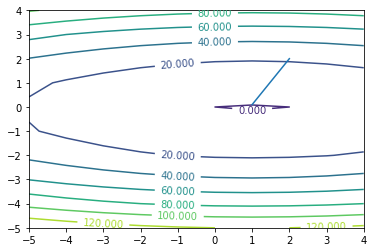

In [16]:
x = np.arange(-x_lim, x_lim, delta)
y = np.arange(-y_lim, y_lim, delta)
X, Y = np.meshgrid(x, y)
Z =1/2 * (diag_1 * X **2 + diag_2 * Y ** 2) - b1 * X + b2 * Y
fig, ax = plt.subplots()
x1 = x_list[::2]
x2 = x_list[1::2]
ax.plot(x1,x2)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
print(f_func([x1[-1],x2[-1]]))

In [42]:
Nx = 2
N_iter = 10
x_lim = 10
y_lim = 10
delta = 1

c1 = 0.25
c2 = 0.45

x_sol_list = []

x_init = ca.DM([2.5,2.5])

x_SX = ca.SX.sym('x',Nx)

f = x_SX[0] ** 2 + ca.sin(x_SX[1]) 

f_func = ca.Function("f_func",[x_SX],[f])
H,g = ca.hessian(f,x_SX)

grad_func = ca.Function("grad_func", [x_SX],[g])
hessian_func = ca.Function("hessian_func", [x_SX],[H])

1.36855
1.36855
1.36855
1.36855
1.36855
1.36855
1.36855
1.36855
1.36855
1.36855


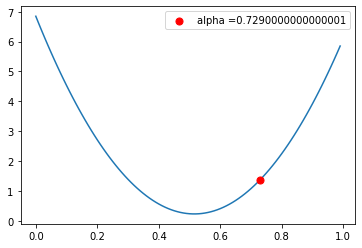

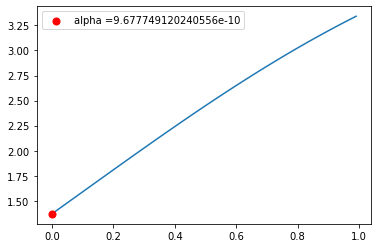

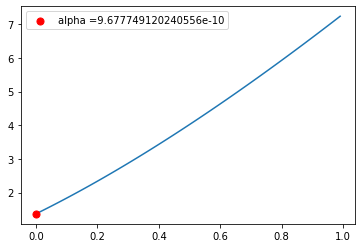

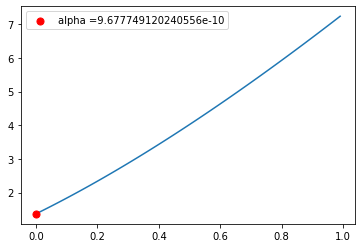

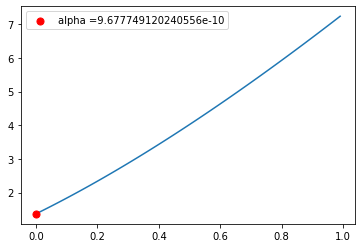

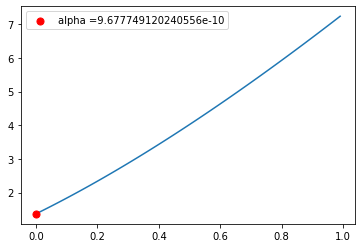

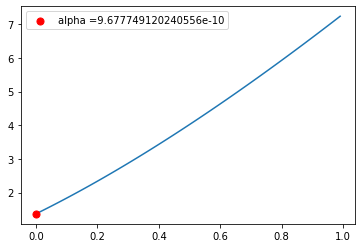

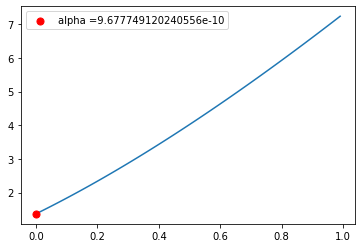

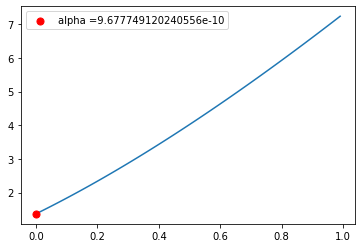

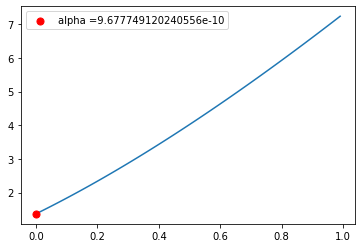

In [43]:
grad_0 = grad_func(x_init)
f0 = f_func(x_init)
p0 = - grad_0

xk = x_init
fk = f0
grad_k = grad_0
pk = p0
for i in range(N_iter):
    alpha_k = strong_Wolfe_condition(f_func, grad_func, c1, c2, xk, pk)
    plot_phi(f_func,xk,pk,alpha_k)
    xk_next = xk + alpha_k * pk
    
    grad_k_next = f_func(xk_next)
#     beta_k_next = (grad_k_next.T @ grad_k_next) / (grad_k.T @ grad_k)
    beta_k_next = (grad_k_next.T @ (grad_k_next - grad_k)) / (grad_k.T @ grad_k)
    
    
    pk_next = - grad_k_next + beta_k_next * pk
    
    grad_k = grad_k_next
    pk = pk_next
    xk = xk_next
    print(grad_k)
    x_sol_list += xk.full().flatten().tolist()
    
    

In [44]:
x_sol_list

[-1.1450000000000005,
 3.084033695733715,
 -1.145000000386594,
 3.084033694499048,
 -1.1450000017110447,
 3.0840336931745975,
 -1.1450000030354952,
 3.084033691850147,
 -1.1450000043599458,
 3.084033690525697,
 -1.1450000056843963,
 3.0840336892012465,
 -1.1450000070088469,
 3.084033687876796,
 -1.1450000083332974,
 3.084033686552346,
 -1.145000009657748,
 3.0840336852278956,
 -1.1450000109821985,
 3.0840336839034452]

1.09983


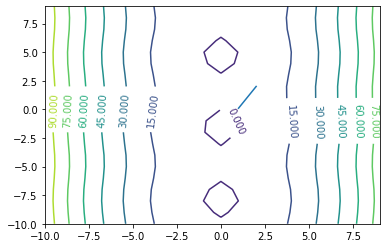

In [45]:
x = np.arange(-x_lim, x_lim, delta)
y = np.arange(-y_lim, y_lim, delta)
X, Y = np.meshgrid(x, y)
Z = X **2 + np.sin(Y) 
fig, ax = plt.subplots()
x1 = x_list[::2]
x2 = x_list[1::2]
ax.plot(x1,x2)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
print(f_func([x1[-1],x2[-1]]))